In [1]:
import os
import re
import glob
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as sk_io
from skimage.transform import resize
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from cvutils.mrcnn.session import init_keras_session
from cvutils import visualize
from celldom import seed
import keras
from keras.preprocessing import image
import wandb
from wandb.keras import WandbCallback

init_keras_session()

#DATA_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03', 'DigitTraining', 'single')
DATA_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'training', 'digit', 'r0.6', 'validated', 'single')
MODEL_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.6', 'digit_model')

MODEL_PATH_HEAD = osp.join(MODEL_DIR, 'single_digit_model_headonly.h5')
MODEL_PATH = osp.join(MODEL_DIR, 'single_digit_model.h5')

DATA_DIR, MODEL_DIR

Using TensorFlow backend.


('/lab/data/celldom/dataset/training/digit/r0.6/validated/single',
 '/lab/data/celldom/model/r0.6/digit_model')

In [2]:
!ls $DATA_DIR | head -n 1

BF_ST_000_APT_000Day0-APT-0-0.jpeg
ls: write error: Broken pipe


In [3]:
def get_actual_digit(file):
    return osp.basename(file).replace('.jpeg', '').split('-')[-1]

def load_images():
    res = []
    for f in glob.glob(osp.join(DATA_DIR, '*.jpeg')):
        digit = get_actual_digit(f)
        img = sk_io.imread(osp.join(DATA_DIR, f))
        res.append((digit, img, f))
    res = pd.DataFrame(res, columns=['digit', 'img', 'file'])
    res['digit'] = res['digit'].astype(int)
    return res

In [4]:
df = load_images()

In [5]:
# r0.2 num files = 2372, r0.6 = 3219
len(df)

3218

In [6]:
df['digit'].value_counts()

0    1488
1     526
2     185
4     180
3     174
5     155
6     133
8     132
7     123
9     122
Name: digit, dtype: int64

In [7]:
dtypes = df['img'].apply(lambda v: v.dtype)
assert np.all(dtypes == np.uint8)
dtypes.value_counts()

uint8    3218
Name: img, dtype: int64

In [8]:
pd.DataFrame([r['img'].shape for _, r in df.iterrows()]).describe()

,0,1
count,3218.000000,3218.000000
mean,53.485084,38.491610
std,4.015814,5.142189
min,22.000000,19.000000
25%,53.000000,35.000000
50%,55.000000,41.000000
75%,56.000000,42.000000
max,58.000000,46.000000


In [9]:
from sklearn.model_selection import train_test_split
idx = np.arange(len(df))

# Vary test_size (starting large) to get a sense of accuracy with a bigger sample and then decrease for final model
idx_train, idx_test = train_test_split(idx, test_size=.2, random_state=seed, stratify=df['digit'])
df_train, df_test = df.iloc[idx_train], df.iloc[idx_test]

len(df_train), len(df_test)

(2574, 644)

In [10]:
pd.concat([df_train['digit'].value_counts(normalize=True), df_test['digit'].value_counts(normalize=True)], axis=1)

,digit,digit
0,0.462315,0.462733
1,0.163559,0.163043
2,0.057498,0.057453
3,0.054002,0.054348
4,0.055944,0.055901
5,0.048174,0.048137
6,0.041181,0.041925
7,0.038073,0.038820
8,0.041181,0.040373
9,0.038073,0.037267


## Training

In [11]:
%run utils.py

In [12]:
target_shape = (32, 32)

In [13]:
from imgaug import augmenters as iaa
from skimage import img_as_ubyte, img_as_float32

sometimes = lambda aug: iaa.Sometimes(.3, aug)
seq = iaa.Sequential([
    # Simulate out-of-focus
    sometimes(iaa.GaussianBlur(sigma=1.0)),
    
    # Randomly alter scaling and simulate zooming
    sometimes(iaa.Crop(px=(0, 10))),
    
    # Rotate up to 3 degrees and randomly scale
    sometimes(iaa.Affine(rotate=3., scale={"x": (.8, 1.4), "y": (.8, 1.4)}, mode='reflect')),
    
    
    # Randomly alter distribution
    sometimes(iaa.OneOf([
        iaa.Multiply((.8, 1.4)), 
        iaa.Add((-25, 25)),
        iaa.ContrastNormalization((0.8, 1.2))
    ]))
], random_order=True)

def augment(img):
    # img should be provided as float in [0, 1]
    assert img.min() >= 0 and img.max() <= 1.
    img = rescale_intensity(img, out_range=np.uint8).astype(np.uint8)
    res = img_as_float32(seq.augment_image(img))
    #print(res.shape, res.dtype, res.min(), res.max())
    return res

In [14]:
def prep_image(img):
    # Note that gray2rgb will take care of converting from uint8 to float in 0-1
    assert img.dtype == np.uint8
    
    # Convert to 2D with target height/width
    img = gray2rgb(resize(img, target_shape, mode='constant', anti_aliasing=True)).astype(np.float32)
    
    # Rescale by min/max
    img = rescale_intensity(img, out_range=(0, 1))
    
    assert np.all(img <= 1.) and np.all(img >= 0.)
    return img

train_x = np.stack([prep_image(v) for v in df_train['img']], 0)
train_y = keras.utils.to_categorical(df_train['digit'].values, 10)

test_x = np.stack([prep_image(v) for v in df_test['img']], 0)
test_y = keras.utils.to_categorical(df_test['digit'].values, 10)

train_generator = image.ImageDataGenerator(preprocessing_function=augment)
train_batches = train_generator.flow(train_x, y=train_y, seed=seed)

test_generator = image.ImageDataGenerator()
test_batches = test_generator.flow(test_x, y=test_y, seed=seed)

train_x.dtype, train_x.shape, test_x.shape

(dtype('float32'), (2574, 32, 32, 3), (644, 32, 32, 3))

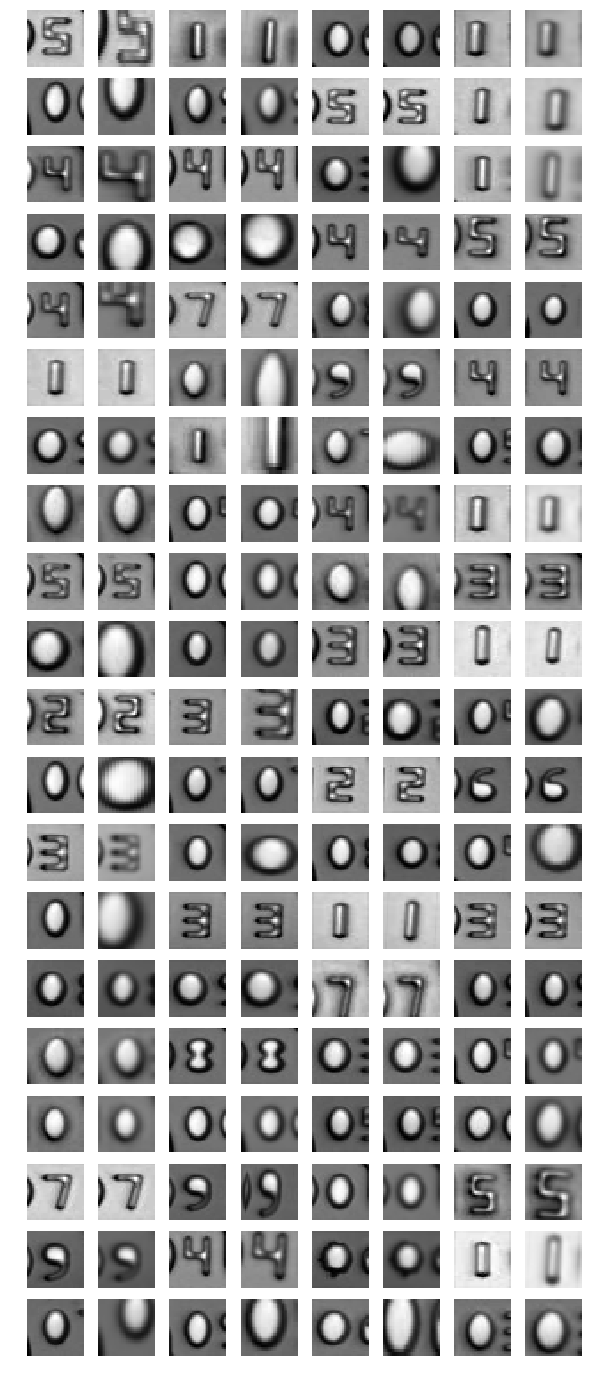

In [16]:
# Visualize augmentations
aug_imgs = []
for img in df_train['img'].sample(n=80):
    aug_imgs.append(prep_image(img))
    aug_imgs.append(augment(prep_image(img)))
visualize.display_images(aug_imgs, cols=8, size=10)

In [17]:
from scipy.stats import describe
describe(aug_imgs[0].ravel())

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.6442587, variance=0.04074707, skewness=-1.2981510162353516, kurtosis=0.6658375877468492)

### Initialize Modeling

In [18]:
MODEL_DIR

'/lab/data/celldom/model/r0.6/digit_model'

In [19]:
!ls $MODEL_DIR

events.out.tfevents.1536785994.18201d6b5c9f  single_digit_model.h5
events.out.tfevents.1536786576.18201d6b5c9f  single_digit_model_headonly.h5


In [20]:
# Clear everything currently in the modeling directory
!rm -rf $MODEL_DIR/*

In [21]:
wandb.init()

W&B Run: https://app.wandb.ai/hammerlab/celldom/runs/zd10wamk
Wrap your training loop with `with wandb.monitor():` to display live results.


W&B Run https://app.wandb.ai/hammerlab/celldom/runs/zd10wamk

### Run Training

In [22]:
MODEL_DIR

'/lab/data/celldom/model/r0.6/digit_model'

In [23]:
if not osp.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [24]:
!ls $MODEL_DIR

In [25]:
#model = get_digit_model(input_shape=target_shape + (3,), mode='tune')
model = get_digit_model(input_shape=target_shape + (3,), mode='head')
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(lr=.001),
    metrics=['accuracy']
)

# Initialize from pre-trained model
model.load_weights('/lab/repos/svhn/weights.hdf5')

In [26]:
# save_model = keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_acc', mode='max', verbose=0,
#                                              save_best_only=True, save_weights_only=False, period=1)
save_model = keras.callbacks.ModelCheckpoint(MODEL_PATH_HEAD, monitor='val_acc', mode='max', verbose=0,
                                             save_best_only=True, save_weights_only=False, period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')
tensorboard = keras.callbacks.TensorBoard(log_dir=MODEL_DIR)
callbacks = [save_model, early_stopping, tensorboard]

with wandb.monitor(display=False):
    model.fit_generator(
        train_batches, 
        epochs=50,
        callbacks=callbacks + [WandbCallback(save_model=False)],
        validation_data=test_batches
    )

Instructions for updating:
Use the retry module or similar alternatives.
Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/zd10wamk


Epoch 1/50
81/81 [==============================] - 5s 58ms/step - loss: 0.4818 - acc: 0.8626 - val_loss: 0.0310 - val_acc: 0.9907
Epoch 2/50
81/81 [==============================] - 4s 44ms/step - loss: 0.2627 - acc: 0.9248 - val_loss: 0.0211 - val_acc: 0.9938
Epoch 3/50
81/81 [==============================] - 4s 46ms/step - loss: 0.1940 - acc: 0.9468 - val_loss: 0.0146 - val_acc: 0.9953
Epoch 4/50
81/81 [==============================] - 4s 47ms/step - loss: 0.1972 - acc: 0.9490 - val_loss: 0.0150 - val_acc: 0.9953
Epoch 5/50
81/81 [==============================] - 4s 46ms/step - loss: 0.1820 - acc: 0.9508 - val_loss: 0.0145 - val_acc: 0.9938
Epoch 6/50
81/81 [==============================] - 4s 45ms/step - loss: 0.1388 - acc: 0.9632 - val_loss: 0.0092 - val_acc: 0.9953
Epoch 7/50
81/81 [==============================] - 4s 46ms/step - loss: 0.1128 - acc: 0.9699 - val_loss: 0.0079 - val_acc: 0.9969
Epoch 8/50
81/81 [==============================] - 4s 46ms/step - loss: 0.0995 - a

### Fine-Tuning

In [27]:
model = get_digit_model(input_shape=target_shape + (3,), mode='tune')
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(lr=.0001),
    metrics=['accuracy']
)

# Initialize from pre-trained model
model.load_weights(MODEL_PATH_HEAD)

In [29]:
save_model = keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_acc', mode='max', verbose=0,
                                             save_best_only=True, save_weights_only=False, period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')
tensorboard = keras.callbacks.TensorBoard(log_dir=MODEL_DIR)
callbacks = [save_model, early_stopping, tensorboard]

with wandb.monitor(display=False):
    model.fit_generator(
        train_batches, 
        epochs=100,
        callbacks=callbacks + [WandbCallback(save_model=False)],
        validation_data=test_batches
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/zd10wamk


Epoch 1/50
81/81 [==============================] - 4s 48ms/step - loss: 0.0287 - acc: 0.9915 - val_loss: 1.1687e-05 - val_acc: 1.0000
Epoch 2/50
81/81 [==============================] - 4s 47ms/step - loss: 0.0336 - acc: 0.9915 - val_loss: 1.2508e-05 - val_acc: 1.0000
Epoch 3/50
81/81 [==============================] - 4s 48ms/step - loss: 0.0340 - acc: 0.9900 - val_loss: 1.1836e-05 - val_acc: 1.0000
Epoch 4/50
81/81 [==============================] - 4s 48ms/step - loss: 0.0400 - acc: 0.9879 - val_loss: 9.9127e-06 - val_acc: 1.0000
Epoch 5/50
81/81 [==============================] - 4s 48ms/step - loss: 0.0163 - acc: 0.9946 - val_loss: 9.4697e-06 - val_acc: 1.0000
Epoch 6/50
81/81 [==============================] - 4s 46ms/step - loss: 0.0302 - acc: 0.9923 - val_loss: 1.0757e-05 - val_acc: 1.0000
Epoch 7/50
81/81 [==============================] - 4s 48ms/step - loss: 0.0313 - acc: 0.9915 - val_loss: 9.0108e-06 - val_acc: 1.0000
Epoch 8/50
81/81 [==============================] - 4s 

## Inference 

In [30]:
model = keras.models.load_model(MODEL_PATH)

In [37]:
inf_x, inf_y = test_x, test_y
#inf_x, inf_y = train_x, train_y
inf_y = np.argmax(inf_y, axis=1)
inf_x.shape, inf_y.shape

((644, 32, 32, 3), (644,))

In [38]:
inf_y_pred = model.predict_classes(inf_x)
inf_y_pred.shape

(644,)

In [39]:
# Overall accuracy
(inf_y_pred == inf_y).mean()

1.0

In [40]:
pd.DataFrame(dict(pred=inf_y_pred, true=inf_y)).groupby(['pred', 'true']).size().unstack().fillna(0)\
    .style.background_gradient(high=.7)

true,0,1,2,3,4,5,6,7,8,9
pred,,,,,,,,,,
0,298,0,0,0,0,0,0,0,0,0
1,0,105,0,0,0,0,0,0,0,0
2,0,0,37,0,0,0,0,0,0,0
3,0,0,0,35,0,0,0,0,0,0
4,0,0,0,0,36,0,0,0,0,0
5,0,0,0,0,0,31,0,0,0,0
6,0,0,0,0,0,0,27,0,0,0
7,0,0,0,0,0,0,0,25,0,0
8,0,0,0,0,0,0,0,0,26,0


#### Show Misclassified Instances (if any)

In [41]:
misclassified = np.argwhere(inf_y_pred != inf_y).ravel()

In [42]:
len(misclassified)

0

In [48]:
misclassified

array([ 183,  338, 1991])

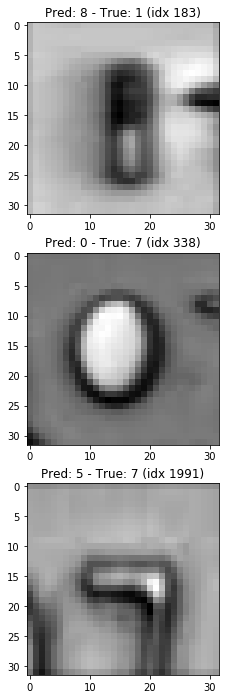

In [50]:
#n_samp = 10
#indexes = pd.Series(list(range(len(pred_y_class)))).sample(n_samp)

n_samp = len(misclassified)
indexes = misclassified

fig, ax = plt.subplots(n_samp, 1)
if n_samp == 1:
    ax = [ax]
fig.set_size_inches(4, n_samp * 4)
for i, idx in enumerate(indexes):
    ax[i].imshow(inf_x[idx])
    ax[i].set_title('Pred: {} - True: {} (idx {})'.format(inf_y_pred[idx], inf_y[idx], idx))

In [43]:
# Use the "idx" above to get the file the example came from
#df.iloc[idx_train[338]]['file']

In [44]:
MODEL_PATH

'/lab/data/celldom/model/r0.6/digit_model/single_digit_model.h5'

In [45]:
!cp /lab/data/celldom/model/r0.6/digit_model/single_digit_model.h5 /lab/data/celldom/.celldom/cache/models/single_digit_model.h5